In [1]:
from dolfin import *
parameters["form_compiler"]["representation"] = 'quadrature'
parameters["form_compiler"]["representation"] = "tsfc"
import warnings
from ffc.quadrature.deprecation import QuadratureRepresentationDeprecationWarning
warnings.simplefilter("once", QuadratureRepresentationDeprecationWarning)
import numpy as np
import matplotlib.pyplot as plt

# Test for PETSc
if not has_linear_algebra_backend("PETSc"):
    print("DOLFIN has not been configured with PETSc. Exiting.")
    exit()

# Set backend to PETSC
parameters["linear_algebra_backend"] = "PETSc"

def build_nullspace(V, x):
    """Function to build nullspace for 2D/3D elasticity"""

    # Get geometric dim
    gdim = V.mesh().geometry().dim()
    assert gdim == 2 or gdim == 3

    # Set dimension of nullspace
    dim = 3 if gdim == 2 else 6

    # Create list of vectors for null space
    nullspace_basis = [x.copy() for i in range(dim)]

    # Build translational null space basis
    for i in range(gdim):
        V.sub(i).dofmap().set(nullspace_basis[i], 1.0);

    # Build rotational null space basis
    if gdim == 2:
        V.sub(0).set_x(nullspace_basis[2], -1.0, 1);
        V.sub(1).set_x(nullspace_basis[2], 1.0, 0);
    elif gdim == 3:
        V.sub(0).set_x(nullspace_basis[3], -1.0, 1);
        V.sub(1).set_x(nullspace_basis[3],  1.0, 0);

        V.sub(0).set_x(nullspace_basis[4],  1.0, 2);
        V.sub(2).set_x(nullspace_basis[4], -1.0, 0);

        V.sub(2).set_x(nullspace_basis[5],  1.0, 1);
        V.sub(1).set_x(nullspace_basis[5], -1.0, 2);

    for x in nullspace_basis:
        x.apply("insert")

    return VectorSpaceBasis(nullspace_basis)

In [2]:
def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    points = mesh.points[:, :2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells})
    return out_mesh

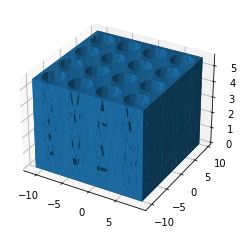

In [3]:
import os
import meshio

#msh file path = /mnt/d/Research Projects/FEniCS/design/msh files/Circle3x4 30062023.msh
#xdmf file path = /mnt/d/Research Projects/FEniCS/design/xdmf files

xdmf_files_folder = '/mnt/d/Research Projects/FEniCS/design/xdmf files'

msh_path = '/mnt/d/Research Projects/FEniCS/design/msh files/Circle4x4_3006203.msh'
msh = meshio.read(msh_path)
tetra_mesh = create_mesh(msh, "tetra")
xdmf_path = os.path.join(xdmf_files_folder, f"{msh_path[:-4]}.xdmf")
meshio.write(xdmf_path, tetra_mesh)

mesh = Mesh()
with XDMFFile(xdmf_path) as infile:
    infile.read(mesh)
plot(mesh);

In [4]:
# Find the range along x, y, and z axes
x_min, x_max = mesh.coordinates()[:, 0].min(), mesh.coordinates()[:, 0].max()
y_min, y_max = mesh.coordinates()[:, 1].min(), mesh.coordinates()[:, 1].max()
z_min, z_max = mesh.coordinates()[:, 2].min(), mesh.coordinates()[:, 2].max()

print("X : [ {}, {} ]".format(x_min, x_max))
print("Y : [ {}, {} ]".format(y_min, y_max))
print("Z : [ {}, {} ]".format(z_min, z_max))

X : [ -11.03541004964499, 8.964589950354998 ]
Y : [ -10.49999999999999, 9.500000000000002 ]
Z : [ 0.0, 5.6 ]


In [5]:
# Calculate the scaling factors for x, y, and z directions
x_range = x_max - x_min
y_range = y_max - y_min
z_range = z_max - z_min

# Rescale the domain in all three directions from -1 to 1
mesh.coordinates()[:, 0] = -1 + 2 * (mesh.coordinates()[:, 0] - x_min) / x_range
mesh.coordinates()[:, 1] = -1 + 2 * (mesh.coordinates()[:, 1] - y_min) / y_range
mesh.coordinates()[:, 2] = -1 + 2 * (mesh.coordinates()[:, 2] - z_min) / z_range

In [6]:
x_min_scaled, x_max_scaled = mesh.coordinates()[:, 0].min(), mesh.coordinates()[:, 0].max()
y_min_scaled, y_max_scaled = mesh.coordinates()[:, 1].min(), mesh.coordinates()[:, 1].max()
z_min_scaled, z_max_scaled = mesh.coordinates()[:, 2].min(), mesh.coordinates()[:, 2].max()

print("X Range: ({}, {})".format(x_min_scaled, x_max_scaled))
print("Y Range: ({}, {})".format(y_min_scaled, y_max_scaled))
print("Z Range: ({}, {})".format(z_min_scaled, z_max_scaled))


X Range: (-1.0, 1.0)
Y Range: (-1.0, 1.0)
Z Range: (-1.0, 1.0)


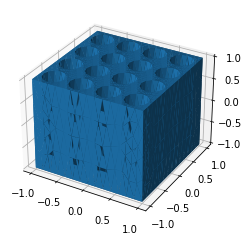

In [7]:
plot(mesh);

In [9]:
# E_value = float(input("Please enter the value for Elastic Modulus: ")) ## enter 20e3 if E = 20 GPa [Eacrylic = 3 GPa]
E = Constant(3e3)
# nu_value = float(input("Please enter the value for Poisson's Ratio: ")) ## acrylic sheet = 0.37
nu = Constant(0.37)
# sig0_value = float(input("Please enter the value for Yield Strength: ")) ## enter 250. if sig_YS = 250 MPa, sigYS = 75 MPa
sig0 = Constant(120) 

lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2./(1+nu)
Et = E/100.  
H = E*Et/(E-Et)  

In [10]:
deg_u = 2 
deg_stress = 2
V = VectorFunctionSpace(mesh, "CG", deg_u)
We = VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=6, quad_scheme='default')
W = FunctionSpace(mesh, We)
W0e = FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')
W0 = FunctionSpace(mesh, W0e)

In [11]:
sig = Function(W)
sig_old = Function(W)
n_elas = Function(W)
beta = Function(W0)
p = Function(W0, name="Cumulative plastic strain")
u = Function(V, name="Total displacement")
du = Function(V, name="Iteration correction")
Du = Function(V, name="Current increment")
v = TrialFunction(V)
u_ = TestFunction(V)
P0 = FunctionSpace(mesh, "DG", 0)
p_avg = Function(P0, name="Plastic strain")

In [12]:
x0_value = int(input("Please enter the 0, 1 or 2 to decide x[0], x[1] or x[2]: "))
a = float(input("Enter lower bound value: "))
b = float(input("Enter upper bound value: "))

class bottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[x0_value], a, 0.01)
    
class top(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[x0_value], b, 0.01)

boundaries = MeshFunction("size_t", mesh, mesh.geometry().dim() - 1)

bottom().mark(boundaries, 1)
top().mark(boundaries, 2)

loading = Expression("-t", t=0, degree=1)

bc_bottom = DirichletBC(V, Constant((0., 0., 0.)), boundaries, 1)

ds = Measure("ds")(subdomain_data=boundaries)
n = FacetNormal(mesh)

bc_u = [bc_bottom]

def F_ext(v):
    return loading*dot(n, v)*ds(2)

Please enter the 0, 1 or 2 to decide x[0], x[1] or x[2]: 1
Enter lower bound value: -1
Enter upper bound value: 1


In [13]:
def eps(v):
    e = sym(grad(v))
    return as_tensor([[e[0, 0], e[0, 1], e[0, 2]],
                      [e[0, 1], e[1, 1], e[1, 2]],
                      [e[0, 2], e[1, 2], e[2, 2]]])

def sigma(eps_el):
    return lmbda*tr(eps_el)*Identity(3) + 2*mu*eps_el

def as_3D_tensor(X):
    return as_tensor([[X[0], X[3], X[4]],
                      [X[3], X[1], X[5]],
                      [X[4], X[5], X[2]]])

In [14]:
ppos = lambda x: (x+abs(x))/2.
def proj_sig(deps, old_sig, old_p):
    sig_n = as_3D_tensor(old_sig)
    sig_elas = sig_n + sigma(deps)
    s = dev(sig_elas)
    sig_eq = sqrt(3/2.*inner(s, s))
    f_elas = sig_eq - sig0 - H*old_p
    dp = ppos(f_elas)/(3*mu+H)
    n_elas = s/sig_eq*ppos(f_elas)/f_elas
    beta = 3*mu*dp/sig_eq
    new_sig = sig_elas-beta*s
    return as_vector([new_sig[0, 0], new_sig[1, 1], new_sig[2, 2], new_sig[0, 1], new_sig[0, 2], new_sig[1, 2]]), \
           as_vector([n_elas[0, 0], n_elas[1, 1], n_elas[2, 2], n_elas[0, 1], n_elas[0, 2], n_elas[1, 2]]), \
           beta, dp

In [15]:
def sigma_tang(e):
    N_elas = as_3D_tensor(n_elas)
    return sigma(e) - 3*mu*(3*mu/(3*mu+H)-beta)*inner(N_elas, e)*N_elas-2*mu*beta*dev(e)

In [16]:
metadata = {"quadrature_degree": deg_stress, "quadrature_scheme": "default"}
dxm = dx(metadata=metadata)

a = inner(eps(v), sigma_tang(eps(u_)))*dxm
L = -inner(eps(u_), as_3D_tensor(sig))*dxm + F_ext(u_)

In [17]:
def local_project(v, V, u=None):
    dv = TrialFunction(V)
    v_ = TestFunction(V)
    a_proj = inner(dv, v_)*dxm
    b_proj = inner(v, v_)*dxm
    solver = LocalSolver(a_proj, b_proj)
    solver.factorize()
    if u is None:
        u = Function(V)
        solver.solve_local_rhs(u)
        return u
    else:
        solver.solve_local_rhs(u)
        return

In [18]:
sig_n1 = as_3D_tensor(sig)
s1 = dev(sig_n1)
Vs = FunctionSpace(mesh, "DG", 0)
sig_eq1 = local_project(sqrt(3/2.*inner(s1, s1)), Vs)
vm = sig_eq1.vector().max()
print("max_vonmises: ",vm)

max_vonmises:  0.0


In [19]:
w  = float(input("Enter the value of plastic strain above which the simulation stops: "))
w1 = float(input("Enter x-coordinate of displacement of a point: "))
w2 = float(input("Enter y-coordinate of displacement of a point: "))
w3 = float(input("Enter z-coordinate of displacement of a point: "))
w4 = int(input("Enter the displacement in which direction; 0, 1 or 2 : "))

Enter the value of plastic strain above which the simulation stops: 0.1
Enter x-coordinate of displacement of a point: 0
Enter y-coordinate of displacement of a point: -1
Enter z-coordinate of displacement of a point: 1
Enter the displacement in which direction; 0, 1 or 2 : 1


In [20]:
Nitermax, tol = 200, 1e-8  # parameters of the Newton-Raphson procedure
Nincr = 300
load_steps = np.linspace(0, 150, Nincr+1)[1:]
results = np.zeros((Nincr+1, 2))

for (i, t) in enumerate(load_steps):
    
    sig_n1 = as_3D_tensor(sig)
    s1 = dev(sig_n1)
    Vs = FunctionSpace(mesh, "DG", 0)
    sig_eq1 = local_project(sqrt(3/2.*inner(s1, s1)), Vs)
    vm = sig_eq1.vector().max()
    print("vm: ",vm)
        
    loading.t = t

    A, b = assemble_system(a, L, bc_u)
    b0 = b.norm("l2")
    b1 = b0
    Du.interpolate(Constant((0, 0, 0)))
    print("Increment:", str(i+1))
    niter = 0
    while b1/b0 > tol and niter < Nitermax:
        
        null_space = build_nullspace(V, du.vector())
        as_backend_type(A).set_near_nullspace(null_space)

        pc = PETScPreconditioner("petsc_amg")

        PETScOptions.set("mg_levels_ksp_type", "chebyshev")
        PETScOptions.set("mg_levels_pc_type", "jacobi")

        PETScOptions.set("mg_levels_esteig_ksp_type", "cg")
        PETScOptions.set("mg_levels_ksp_chebyshev_esteig_steps", 50)

        solver = PETScKrylovSolver("cg", pc)
        solver.parameters["monitor_convergence"] = False

        solver.set_operator(A);

        solver.solve(du.vector(), b);
                
        Du.assign(Du+du)
        
        deps = eps(Du)
        sig_, n_elas_, beta_, dp_ = proj_sig(deps, sig_old, p)
        
        local_project(sig_, W, sig)
        local_project(n_elas_, W, n_elas)
        local_project(beta_, W0, beta)
        
        A, b = assemble_system(a, L, bc_u)
        b1 = b.norm("l2")
        print("    Residual:", b1)
        niter += 1
        
    u.assign(u+Du)
    p.assign(p+local_project(dp_, W0))
    sig_old.assign(sig)
    p_avg.assign(project(p, P0))
    k = p_avg.vector().max()
    print("max_plastic_strain: ", k)
    if k > w:
        x= P0.tabulate_dof_coordinates()
        max_index = np.argmax(p_avg.vector()[:])
        print("Max_plastic_strain at:", x[max_index])
        break
    results[i+1, :] = (u(w1, w2, w2)[w4], t)

vm:  0.0
Increment: 1
    Residual: 0.0002898421506203419
    Residual: 2.6949400794258243e-09
    Residual: 4.0730683900613046e-12
max_plastic_strain:  0.0
vm:  4.576985095987188
Increment: 2
    Residual: 0.00028984215026077925
    Residual: 2.6954614439027563e-09
    Residual: 1.9500733614157907e-12
max_plastic_strain:  0.0
vm:  9.153970191974267
Increment: 3
    Residual: 0.0002898421458515007
    Residual: 2.6952674390913583e-09
    Residual: 1.4577641087553406e-12
max_plastic_strain:  0.0
vm:  13.730955287961375
Increment: 4
    Residual: 0.0002898421489170795
    Residual: 2.695547396914685e-09
    Residual: 3.649784127202021e-12
max_plastic_strain:  0.0
vm:  18.307940383948456
Increment: 5
    Residual: 0.00028984214913853877
    Residual: 2.6951736203025362e-09
    Residual: 3.398938698086652e-12
max_plastic_strain:  0.0
vm:  22.884925479935543
Increment: 6
    Residual: 0.00028984215082305403
    Residual: 2.6960304131902754e-09
    Residual: 6.091114480035622e-12
max_plastic

    Residual: 0.05166074403428797
    Residual: 0.000316313942639755
    Residual: 1.3300580081967138e-08
    Residual: 2.7505782214290427e-12
max_plastic_strain:  0.06685017336991919
vm:  122.0257628293915
Increment: 45
    Residual: 0.06574980537375286
    Residual: 0.0003588572650700279
    Residual: 2.2206116383268642e-08
    Residual: 3.3810716411862868e-12
max_plastic_strain:  0.07261447270195966
vm:  122.20043856672608
Increment: 46
    Residual: 0.08127667461587605
    Residual: 0.0029230379028730366
    Residual: 6.86245874593192e-07
    Residual: 1.0772930350733968e-11
max_plastic_strain:  0.07875390333513141
vm:  122.38648191924642
Increment: 47
    Residual: 0.09367529946683137
    Residual: 0.0009252086564735152
    Residual: 1.02843869015383e-07
    Residual: 2.915589362227665e-12
max_plastic_strain:  0.08530467162289318
vm:  122.58499004917857
Increment: 48
    Residual: 0.08522343993766811
    Residual: 0.0012696374122691037
    Residual: 1.309232587040878e-07
    Resid

In [21]:
x = results[:, 0]
last_non_zero_index = len(x) - 1
while last_non_zero_index >= 0 and x[last_non_zero_index] == 0:
    last_non_zero_index -= 1
x = x[:last_non_zero_index + 1]

y = results[:, 1]
last_non_zero_index = len(y) - 1
while last_non_zero_index >= 0 and y[last_non_zero_index] == 0:
    last_non_zero_index -= 1
y = y[:last_non_zero_index + 1]

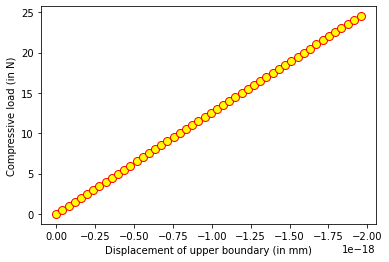

In [22]:
import matplotlib.pyplot as plt
save_path = "/mnt/d/Research Projects/FEniCS/design/plots files"

plt.plot(x, y, "-o", color="red", markerfacecolor="yellow", markersize=8)
plt.xlabel("Displacement of upper boundary (in mm)")
plt.ylabel(r"Compressive load (in N)")
plt.gca().invert_xaxis()

# Set DPI (dots per inch) for the saved image and specify the full path
save_file_path = os.path.join(save_path, "circle4x4.png")
plt.savefig(save_file_path, dpi=900)

# Show the plot (optional)
plt.show()

In [23]:
file_results = XDMFFile("circle4x4.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True
file_results.write(u, 0.)
file_results.write(p_avg, 0.)